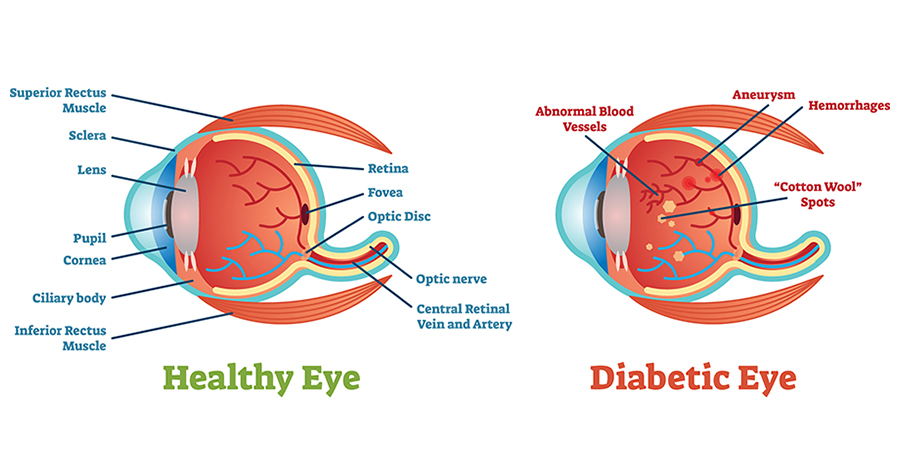

# Non-proliferative diabetic retinopathy

Non-proliferative diabetic retinopathy (NPDR) is the early stage of the disease in which symptoms will be mild or nonexistent. In NPDR, the blood vessels in the retina are weakened. Tiny bulges in the blood vessels, called microaneurysms, may leak fluid into the retina. This leakage may lead to swelling of the macula.

# Proliferative diabetic retinopathy

Proliferative diabetic retinopathy (PDR) is the more advanced form of the disease. At this stage, circulation problems deprive the retina of oxygen. As a result, new, fragile blood vessels can begin to grow in the retina and into the vitreous, the gel-like fluid that fills the back of the eye. The new blood vessels may leak blood into the vitreous, clouding vision.

Other complications of PDR include detachment of the retina due to scar tissue formation and the development of glaucoma. Glaucoma is an eye disease in which there is progressive damage to the optic nerve. In PDR, new blood vessels grow into the area of the eye that drains fluid from the eye. This greatly raises the eye pressure, which damages the optic nerve. If left untreated, PDR can cause severe vision loss and even blindness.

Reference: "Diabetic retinopathy" https://www.aoa.org/healthy-eyes/eye-and-vision-conditions/diabetic-retinopathy?sso=y

So how we can detect Non-proliferative diabetic retinopathy and Proliferative diabetic retinopathy is very important. Especially, if we miss Proliferative diabetic retinopathy, it may cause very serious problem. And if we miss the early stage symptoms, it may cause the delay of prevention.

The data set has 5 classes, "Health", "Mild", "Moderate", "Proliferate" and "Severe". But to get high score by simplifying the data, in this notebook, I classified the data into 3 classes, "Healthy", "Caution" (Mild and Moderate), and "Severe"(Proliferate and Severe).

And I focused on high "Recall",not "Precision", because the most important thing is how we do not miss 'Caution' and 'Severe'.

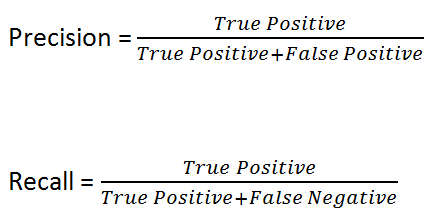

# Importing

In [ ]:
import os
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image
from PIL import UnidentifiedImageError

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
import itertools

import warnings
warnings.filterwarnings('ignore')

In [ ]:
Healthy = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Healthy/')
Mild = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Mild DR/')
Moderate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Moderate DR/')
Proliferate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Proliferate DR/')
Severe = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Severe DR/')

# Data Preprocessing and classify into 3 classes

In [ ]:
img_w, img_h = 225, 225
X = []
y = []

In [ ]:
for i in Healthy:
    try:
        img = Image.open("/kaggle/input/diabetic-retinopathy-dataset/Healthy/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(0)
    except UnidentifiedImageError:
        pass

In [ ]:
for i in Mild:
    try:
        img = Image.open("/kaggle/input/diabetic-retinopathy-dataset/Mild DR/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass

In [ ]:
for i in Moderate:
    try:
        img = Image.open("/kaggle/input/diabetic-retinopathy-dataset/Moderate DR/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass

In [ ]:
for i in Proliferate:
    try:
        img = Image.open("/kaggle/input/diabetic-retinopathy-dataset/Proliferate DR/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(2)
    except UnidentifiedImageError:
        pass

In [ ]:
for i in Severe:
    try:
        img = Image.open("/kaggle/input/diabetic-retinopathy-dataset/Severe DR/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(2)
    except UnidentifiedImageError:
        pass

In [ ]:
X = np.asarray(X)
y = np.asarray(y)
print(X.shape, y.shape)

In [ ]:
x = X.astype('float32')
x /= 255

In [ ]:
num_classes = 3

labels = keras.utils.to_categorical(y, num_classes)
print(labels[0])

# Data split to train, validation and test

In [ ]:
x_train1, x_test, y_train1, y_test = train_test_split(x, labels, test_size = 0.1, random_state=5)
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,test_size=0.1,random_state=5)

print('Number of train: {}'.format(len(x_train)))
print('Number of validation: {}'.format(len(x_val)))
print('Number of test: {}'.format(len(x_test)))

# Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20.,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=30.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=0.2,
    vertical_flip=0.2,
    rescale=None)

datagen.fit(x_train)

# Modeling

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=(225,225,3),include_top=False,weights="imagenet")

In [ ]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [ ]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 3*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'recall',patience = 10,verbose = 1,factor = 0.50, min_lr = 1e-6)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=10)

In [ ]:
model.compile(optimizer='Adam', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)

# Training

In [ ]:
%time
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs = 20,verbose = 1,callbacks=[lrd,mcp,es])

In [ ]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Recall')
plt.plot(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")

y_test_c = np.argmax(y_test, axis=1)
target_names = ["Healty", "Caution", "Severe"]

Y_pred = np.argmax(model.predict(x_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))

# Conclution

As first step, we have to reduce the missed 'Caution' and 'Severe' by this model. In practical, when we get the result 'Caution' or 'Severe', we should examine them again carefully. But we can reduce time and cost by screening　with this kind of model.